In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [2]:
N = 10**3
ns = [10, 50, 100, 150, 200, 500]

a = 5.0
alpha = 0.05
beta = 0.05

z_alpha = norm.ppf(1 - alpha/2)
z_beta  = norm.ppf(1 - beta /2)
z_095 = norm.ppf(0.975)

In [4]:
def generate_sample(dist, n, mu=0.0):
    if dist == 'normal':
        x = np.random.normal(0.0, 1.0, size=n)
    elif dist == 'uniform':
        x = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=n)
    elif dist == 'exp':
        x = np.random.exponential(scale=1.0, size=n) - 1.0
    else:
        raise ValueError("unknown distribution")
    return x + mu


def decision_two_intervals(x,
                           a=a,
                           alpha=alpha,
                           beta=beta,
                           treat_inconclusive_as_H1=True):
    n = len(x)
    x_mean = np.mean(x)
    se = 1.0 / np.sqrt(n)

    lo_b = x_mean - z_beta * se
    hi_b = x_mean + z_beta * se

    if lo_b > -a and hi_b < a:
        return 0

    lo_a = x_mean - z_alpha * se
    hi_a = x_mean + z_alpha * se

    if hi_a < -a or lo_a > a:
        return 1

    if treat_inconclusive_as_H1:
        return 1
    else:
        return -1

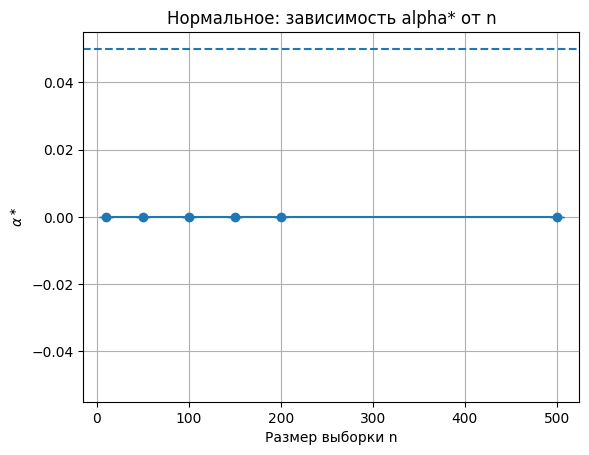

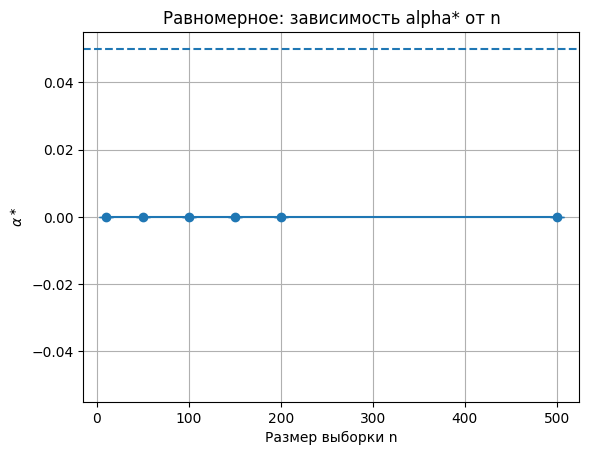

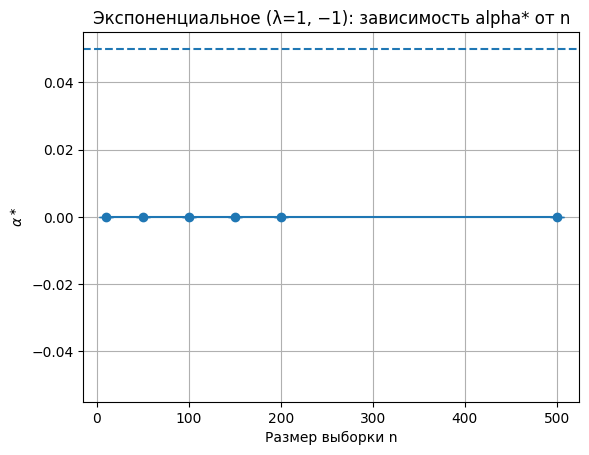

In [5]:
#2
def simulate_alpha_star(dist):
    alphas_star = []
    ci_low = []
    ci_high = []

    for n in ns:
        rejections = 0
        for _ in range(N):
            sample = generate_sample(dist, n, mu=0.0)
            dec = decision_two_intervals(sample)
            if dec == 1:
                rejections += 1

        alpha_star = rejections/N
        alphas_star.append(alpha_star)

        se = np.sqrt(alpha_star * (1 - alpha_star) / N)
        ci_low.append(max(0.0, alpha_star - z_095 * se))
        ci_high.append(min(1.0, alpha_star + z_095 * se))

    return np.array(alphas_star), np.array(ci_low), np.array(ci_high)


dists = ['normal', 'uniform', 'exp']
dist_names = {
    'normal':  'Нормальное',
    'uniform': 'Равномерное',
    'exp': 'Экспоненциальное (λ=1, −1)'
}

results_alpha = {}

for dist in dists:
    alpha_star, ci_lo, ci_hi = simulate_alpha_star(dist)
    results_alpha[dist] = (alpha_star, ci_lo, ci_hi)

    plt.figure()
    plt.errorbar(ns, alpha_star,
                 yerr=[alpha_star - ci_lo, ci_hi - alpha_star],
                 fmt='o-', capsize=5)
    plt.axhline(alpha, linestyle='--')
    plt.xlabel("Размер выборки n")
    plt.ylabel(r'$\alpha^\ast$')
    plt.title(dist_names[dist] + ": зависимость alpha* от n")
    plt.grid(True)
    plt.show()

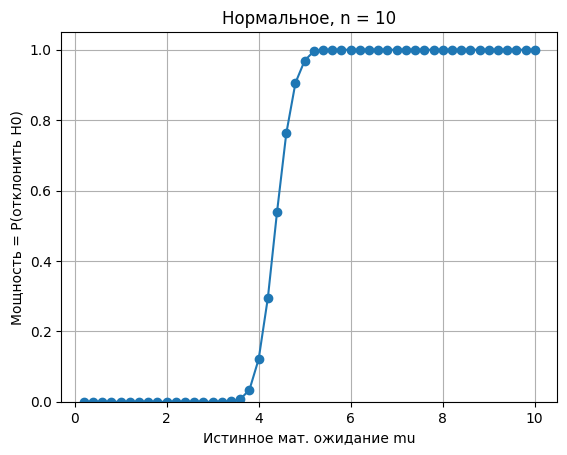

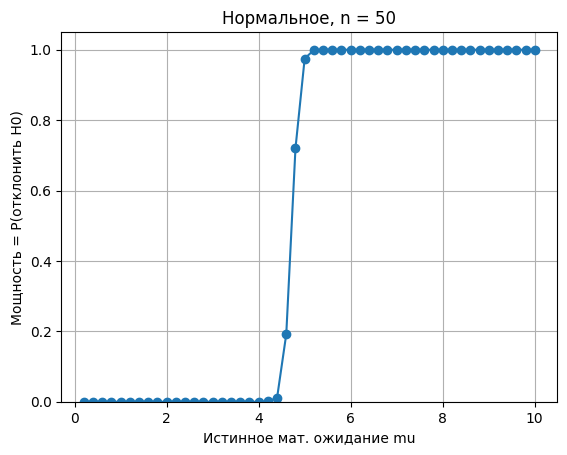

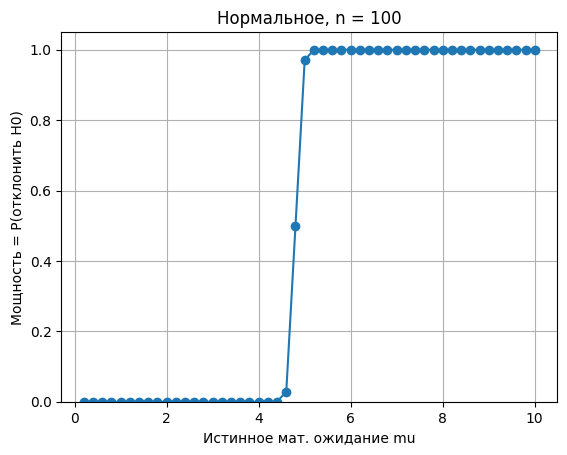

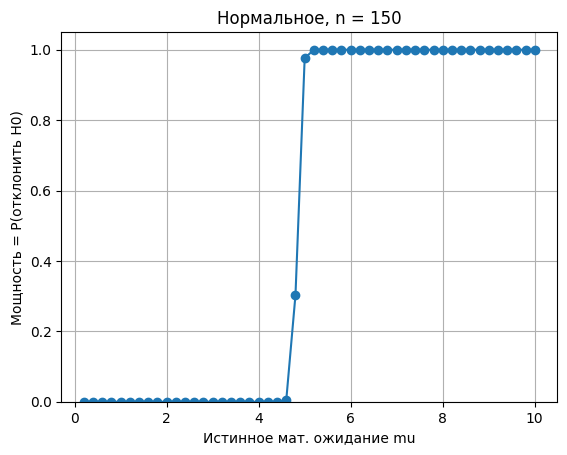

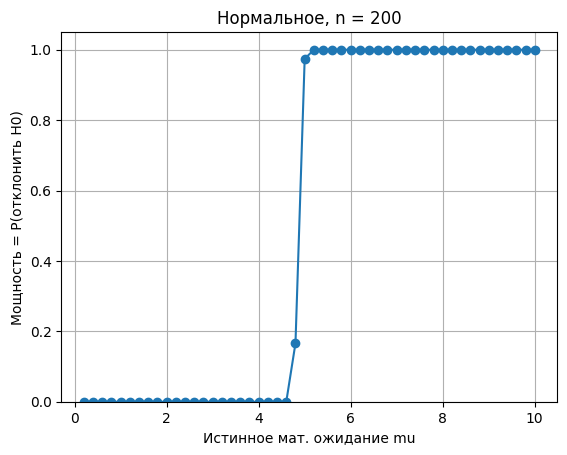

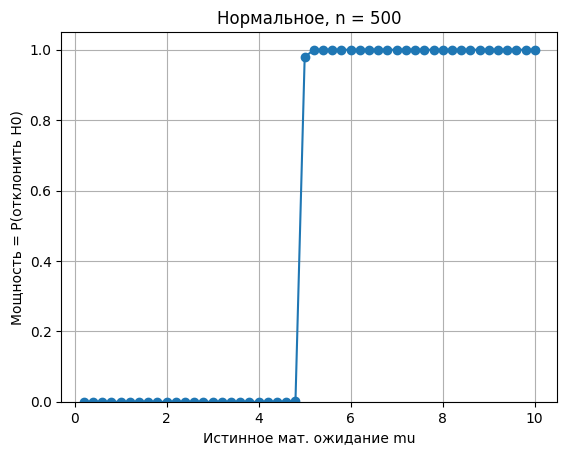

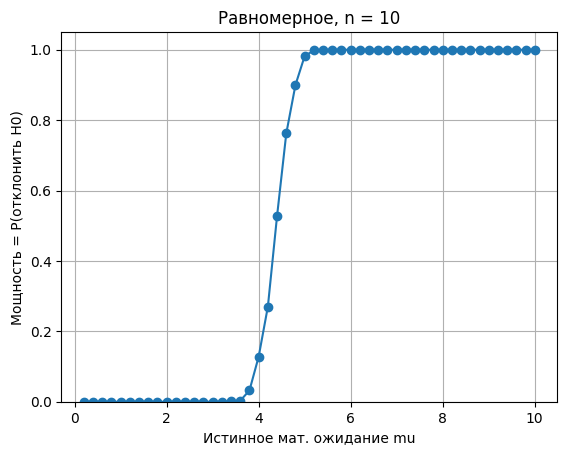

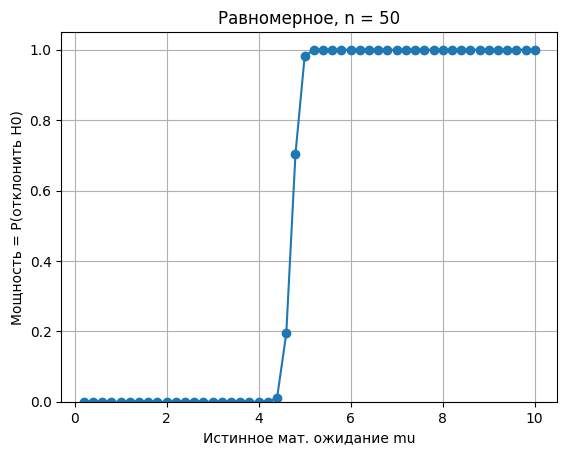

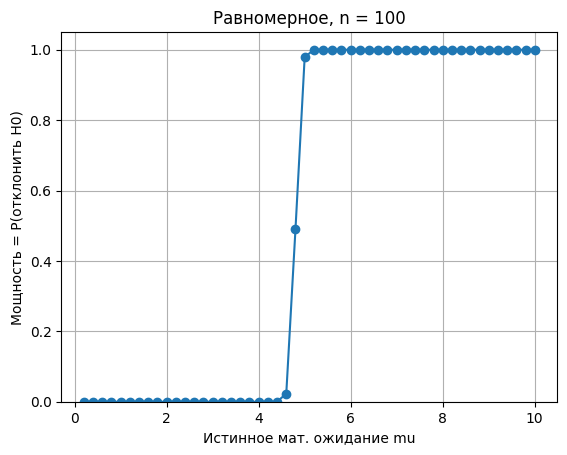

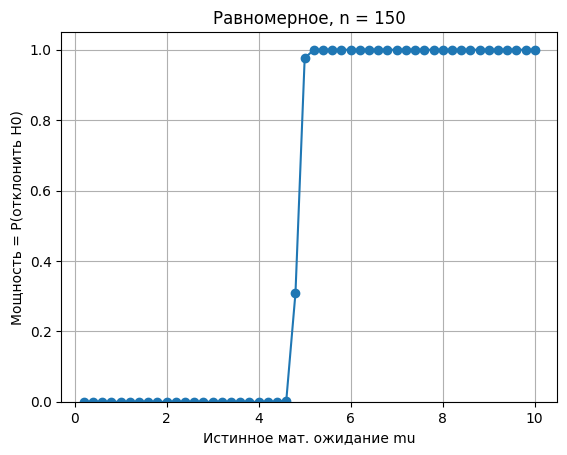

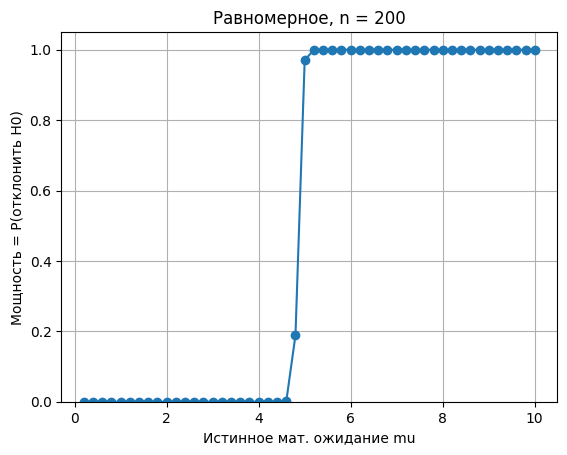

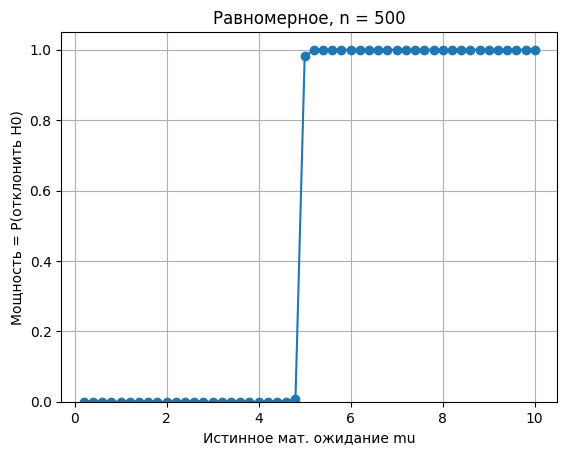

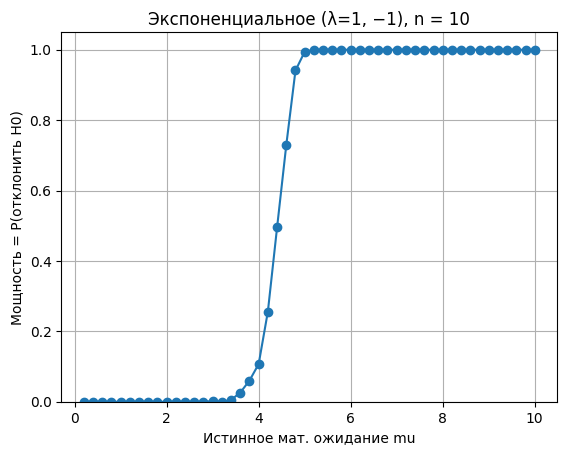

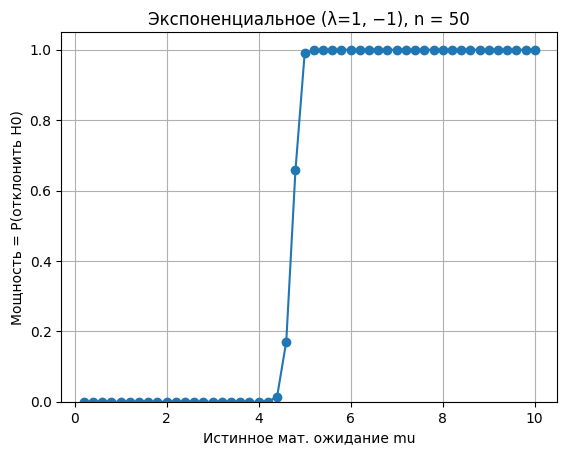

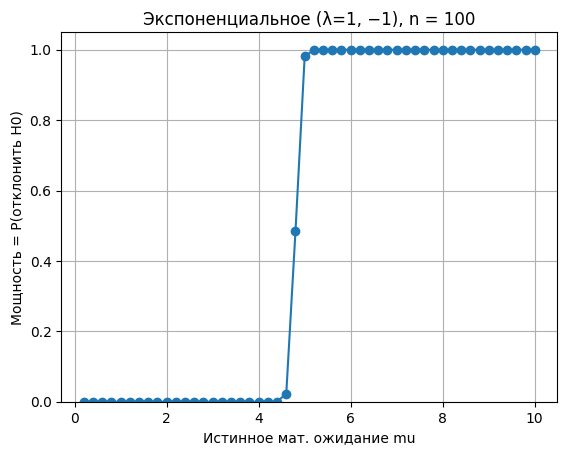

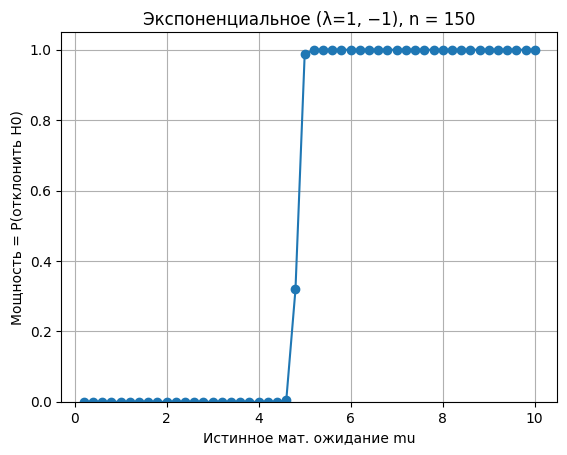

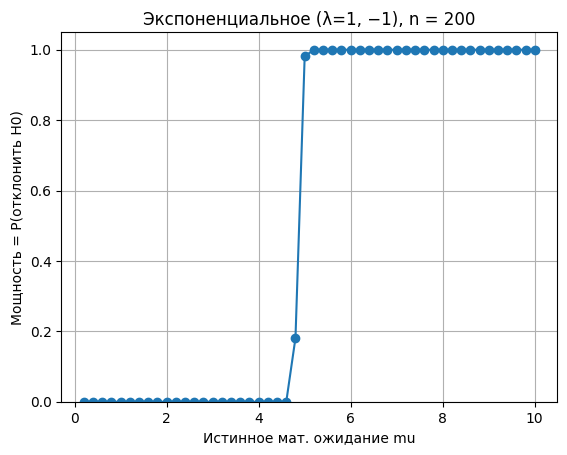

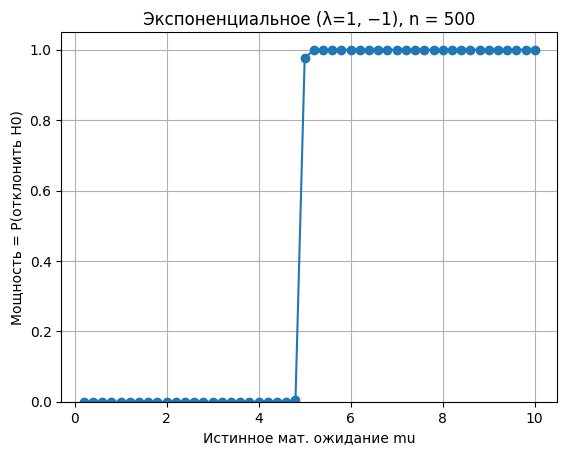

In [7]:
#3
def simulate_power(dist, n, mu_values):
    power = []
    for mu in mu_values:
        rejections = 0
        for _ in range(N):
            sample = generate_sample(dist, n, mu=mu)
            dec = decision_two_intervals(sample)
            if dec == 1:
                rejections += 1
        power.append(rejections / N)
    return np.array(power)

mu_vals = np.arange(0.2, 2 * a + 0.001, 0.2)

results_power = {}

for dist in dists:
    results_power[dist] = {}
    for n in ns:
        power = simulate_power(dist, n, mu_vals)
        results_power[dist][n] = power

        plt.figure()
        plt.plot(mu_vals, power, marker='o')
        plt.xlabel("Истинное мат. ожидание mu")
        plt.ylabel("Мощность = P(отклонить H0)")
        plt.title(f"{dist_names[dist]}, n = {n}")
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.show()

Домашнее задание

In [8]:
from scipy.stats import norm

z_alpha_1s = norm.ppf(1 - alpha)
z_beta_1s  = norm.ppf(1 - beta)

def decision_one_sided(x,
                       a=a,
                       alpha=alpha,
                       beta=beta,
                       treat_inconclusive_as_H1=True):

    n = len(x)
    x_mean = np.mean(x)
    se = 1.0 / np.sqrt(n)
    U_b = x_mean + z_beta_1s * se
    if U_b < a:
        return 0
    L_a = x_mean - z_alpha_1s * se
    if L_a > a:
        return 1

    if treat_inconclusive_as_H1:
        return 1
    else:
        return -1

In [11]:
def simulate_alpha_star_one_sided(dist):
    alphas_star = []
    ci_low = []
    ci_high = []

    for n in ns:
        rejections = 0
        for _ in range(N):
            sample = generate_sample(dist, n, mu=a)
            if decision_one_sided(sample) == 1:
                rejections += 1

        alpha_star = rejections / N
        alphas_star.append(alpha_star)

        se = np.sqrt(alpha_star * (1 - alpha_star) / N)
        ci_low.append(max(0.0, alpha_star - z_095 * se))
        ci_high.append(min(1.0, alpha_star + z_095 * se))

    return np.array(alphas_star), np.array(ci_low), np.array(ci_high)

In [12]:
def simulate_power_one_sided(dist, n, mu_values):
    power = []
    for mu in mu_values:
        rejections = 0
        for _ in range(N):
            sample = generate_sample(dist, n, mu=mu)
            if decision_one_sided(sample) == 1:
                rejections += 1
        power.append(rejections / N)
    return np.array(power)

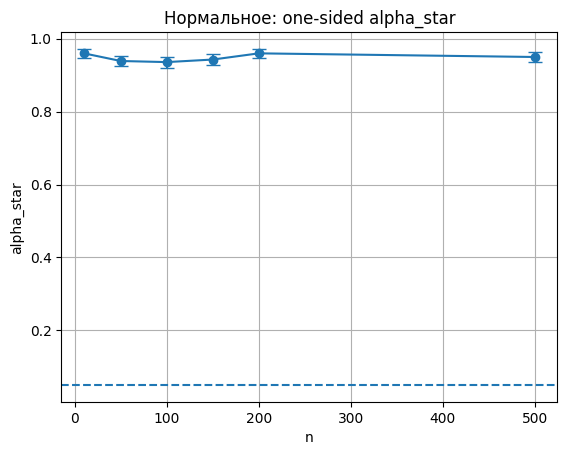

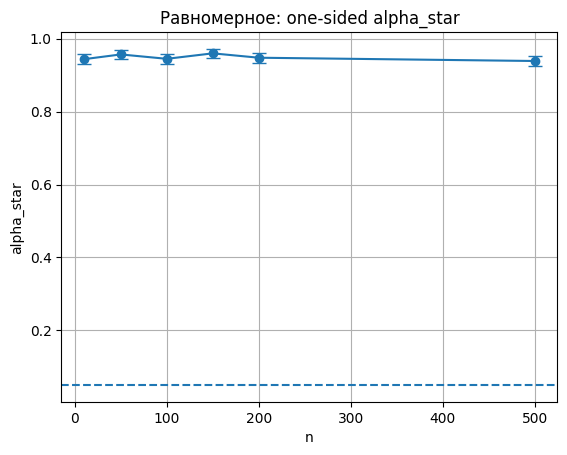

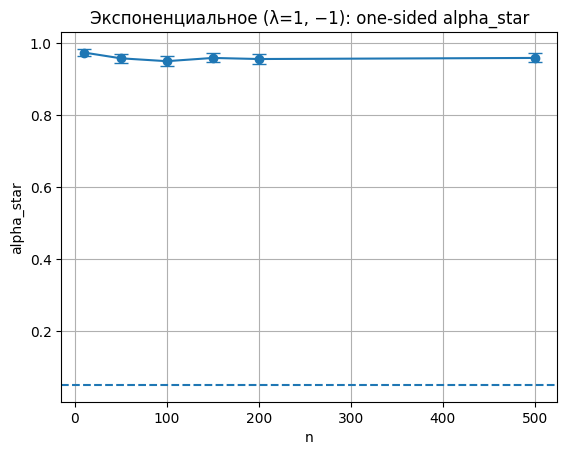

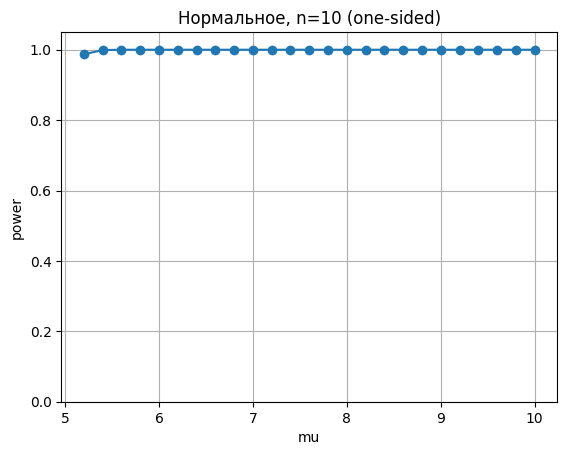

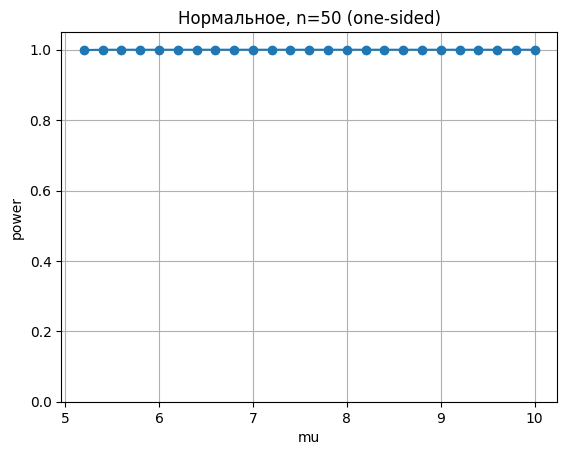

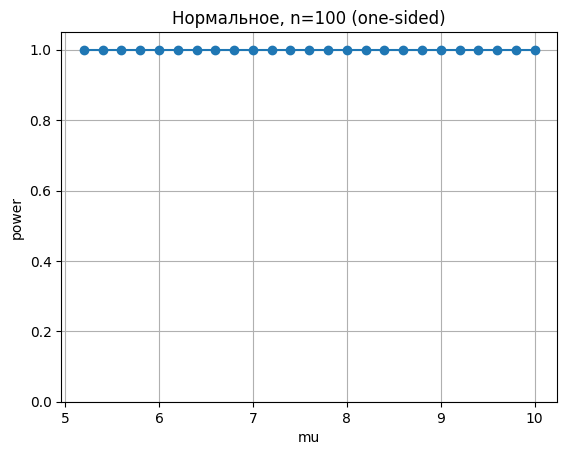

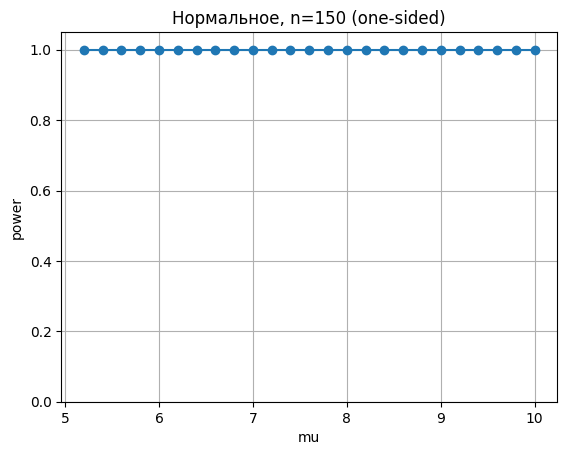

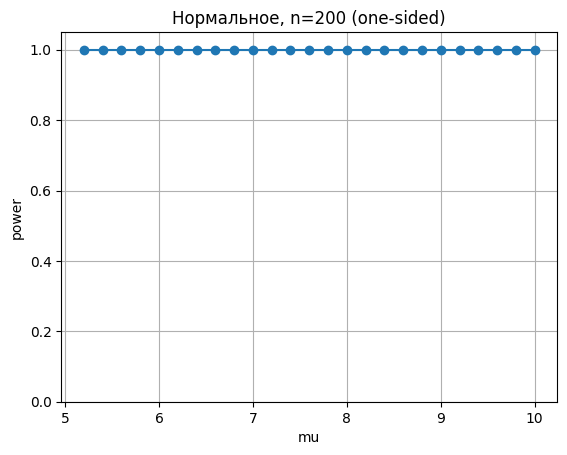

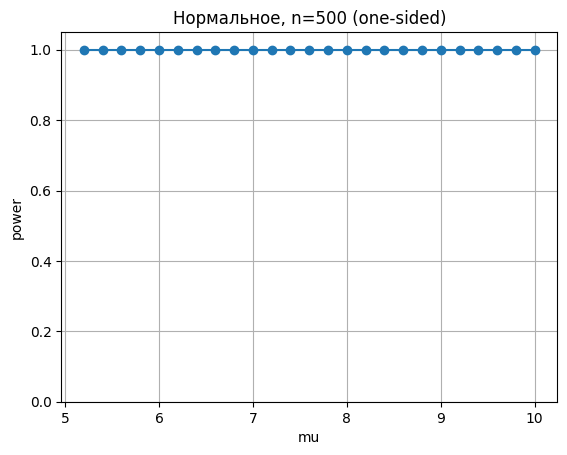

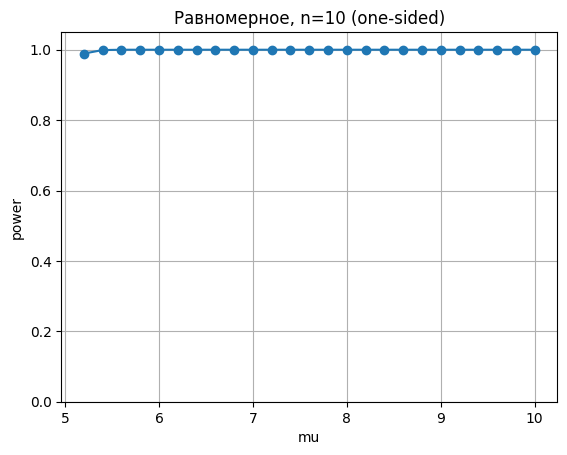

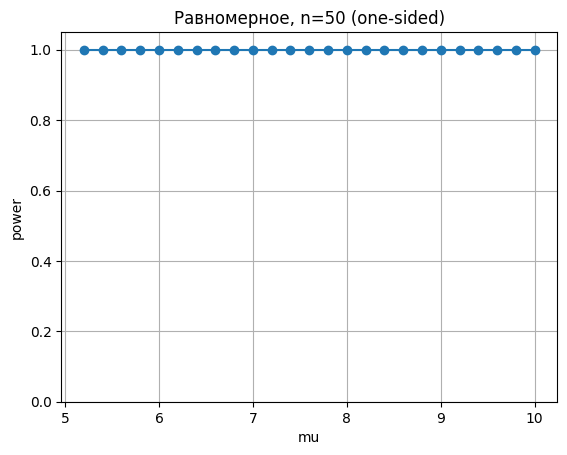

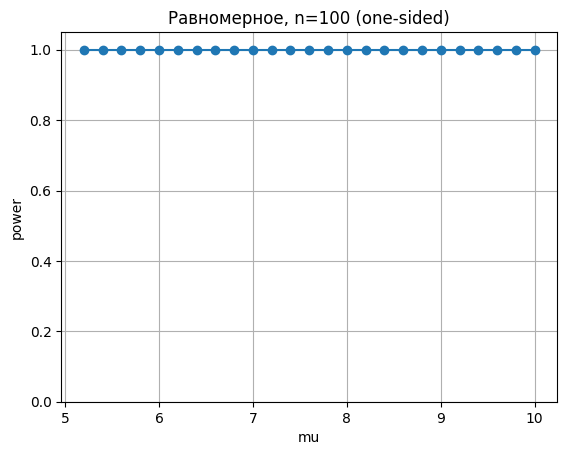

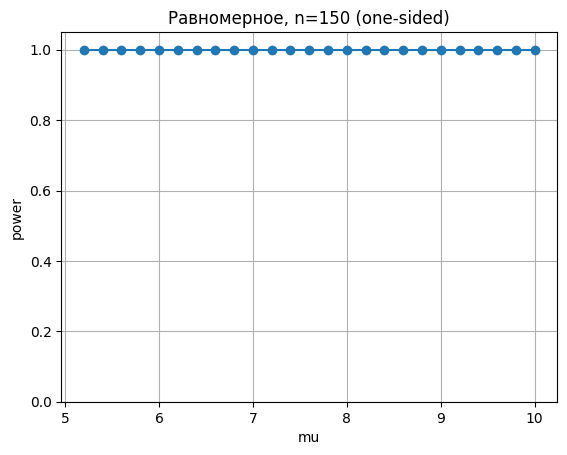

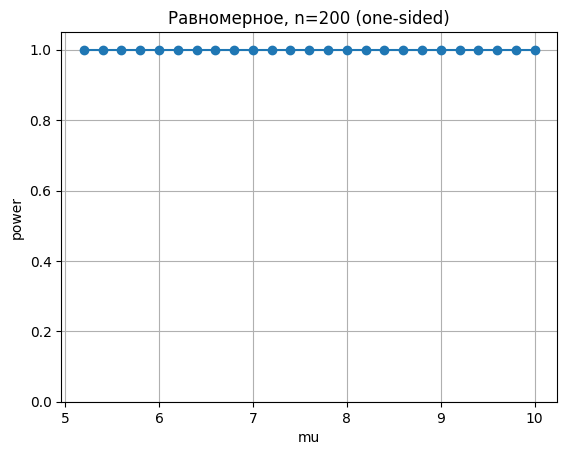

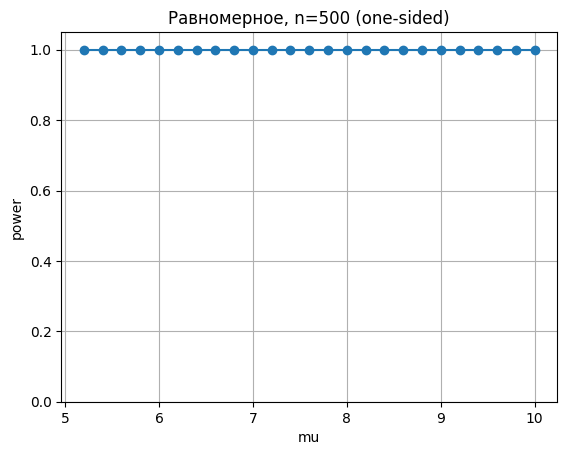

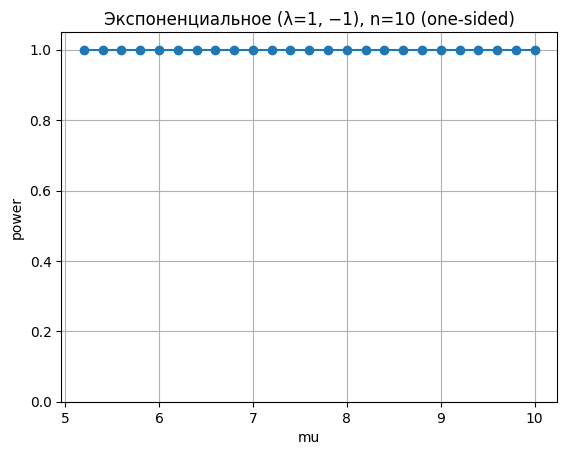

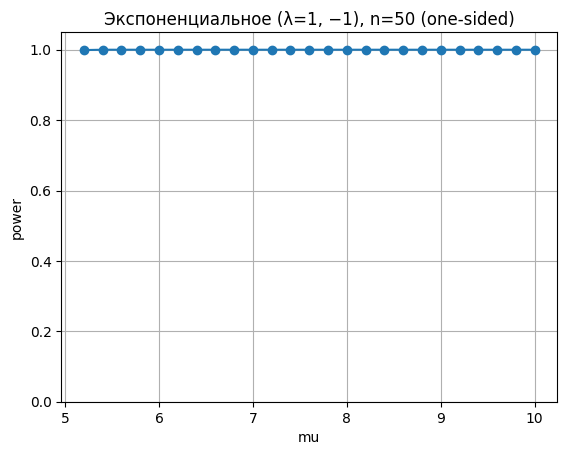

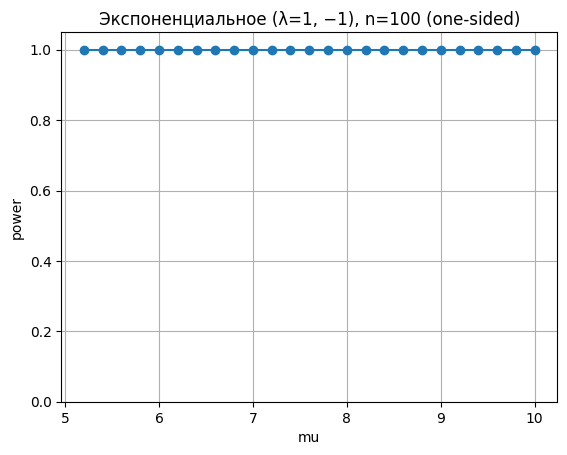

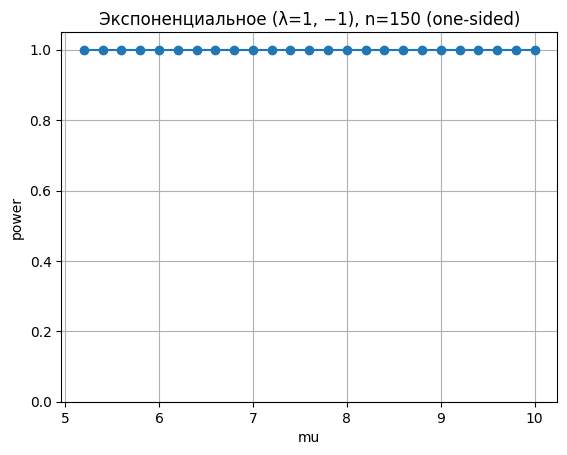

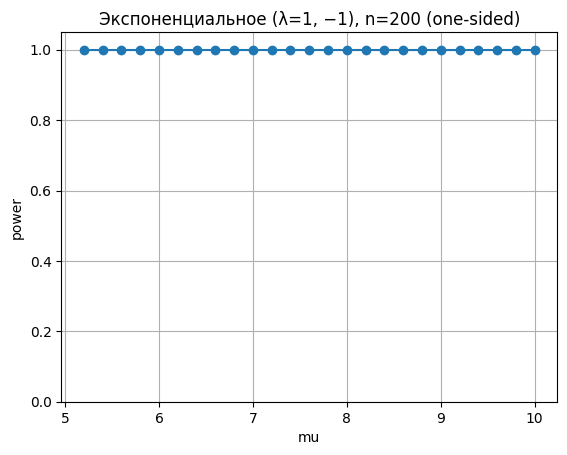

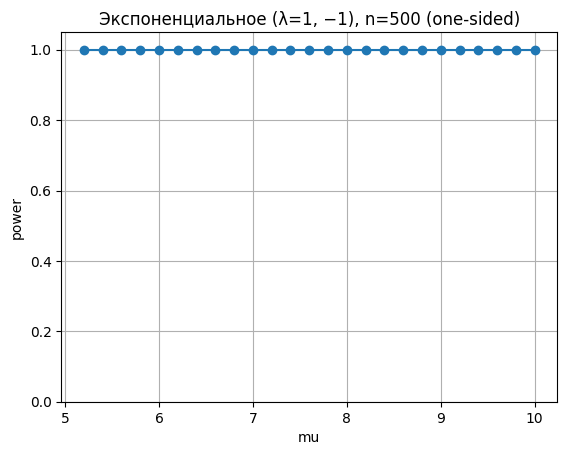

In [13]:
mu_vals_1s = np.arange(a + 0.2, 2 * a + 0.001, 0.2)

for dist in dists:
    alpha_star, ci_lo, ci_hi = simulate_alpha_star_one_sided(dist)

    plt.figure()
    plt.errorbar(ns, alpha_star,
                 yerr=[alpha_star - ci_lo, ci_hi - alpha_star],
                 fmt='o-', capsize=5)
    plt.axhline(alpha, linestyle='--')
    plt.xlabel("n")
    plt.ylabel("alpha_star")
    plt.title(dist_names[dist] + ": one-sided alpha_star")
    plt.grid(True)
    plt.show()

for dist in dists:
    for n in ns:
        power = simulate_power_one_sided(dist, n, mu_vals_1s)
        plt.figure()
        plt.plot(mu_vals_1s, power, marker='o')
        plt.xlabel("mu")
        plt.ylabel("power")
        plt.title(dist_names[dist] + ", n=" + str(n) + " (one-sided)")
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.show()

При односторонней проверке, из-за того что все неясные случаи считаются отклонением нулевой гипотезы, реальный уровень ошибки первого рода получается значительно больше заданного и близок к 1, поэтому критерий почти всегда отвергает H0, особенно при больших размерах выборки.